# Brain Tumor Detection; Comparison of Transfer Learning models with VGG16 and Resnet 50

This Jupyter Notebook demonstrates building a brain tumor detection model using the VGG16 and Resnet 50 pre-trained convolutional neural network (CNN) for transfer learning. Transfer learning leverages the knowledge learned by models on a massive image dataset (ImageNet) to accelerate your brain tumor detection model's training and potentially improve its performance.

**Steps:**

1. **Import Necessary Libraries**
2. **Load and Preprocess Brain Tumor Dataset**
   - Download and prepare the brain tumor dataset
   - Explore the dataset's content and structure (number of images, classes, etc.)
   - Preprocess images: resizing, normalization, data augmentation (optional)
3. **Prepare Dataloader**
4. **Load the Model**
   - Use the deep learning library FAST.AI to load the model pre-trained on ImageNet.
   - Freeze the convolutional base layers of models to retain their learned features.
   - Add custom classification layers suitable for brain tumor detection.
5. **Compile and Train the Model**
  - Define loss function (e.g., binary cross-entropy for binary classification)
   - Choose an optimizer (e.g., Adam)
   - Specify metrics (e.g., accuracy)
   - Train the model on the preprocessed brain tumor dataset
   - Monitor training progress (loss, accuracy) using visualization tools
   - Consider using techniques like early stopping or learning rate scheduling to optimize training
6. **Evaluate the Model**
   - Evaluate the model's performance on a separate test dataset that wasn't used for training.
   - Calculate metrics like accuracy, precision, recall, F1-score, and confusion matrix.
7. **Visualize Results**
   - Visualize intermediate activations using techniques like Grad-CAM to understand which image regions the model focuses on for classification.
   - Generate predictions on new brain tumor images.

**Additional Considerations:**

- Experiment with hyperparameter tuning (e.g., learning rate, batch size) to improve model performance.
- Consider using data augmentation techniques (e.g., random rotations, flips) to artificially increase the dataset size and improve model generalization.


This project can contribute to the advancement of medical image analysis and potentially aid in early diagnosis of brain tumors.


# 1. Import Necessary Libraries

In [1]:
! pip install --upgrade -q kaggle

In [2]:
pip install --upgrade -q fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns
import os

from fastai.vision.all import *
from fastai.imports import *

import ipywidgets
from ipywidgets import widget
import shutil
import warnings

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [5]:
warnings.filterwarnings('ignore')

# 2. Load and Preprocess Brain Tumor Dataset



*   The code utilizes !kaggle datasets download to download the "brain-tumor-detection-mri" dataset from Kaggle.

*   It then extracts the downloaded zip file using !unzip.
*   The code creates directories for the training and testing data within the Colab environment.
*   It further separates images into "no" and "yes" tumor categories within the training directory.
*   DataFrames are created to represent the training and test data, containing image paths and corresponding labels ("no" or "yes").

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moaz47","key":"d4da9a1e0b1fe59c134d985a45a136a6"}'}

In [7]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d abhranta/brain-tumor-detection-mri

Dataset URL: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri
License(s): unknown
 78% 50.0M/64.3M [00:00<00:00, 71.9MB/s]
100% 64.3M/64.3M [00:00<00:00, 85.2MB/s]


In [9]:
! mkdir brain_tumor

! unzip /content/brain-tumor-detection-mri.zip -d brain_tumor

Archive:  /content/brain-tumor-detection-mri.zip
  inflating: brain_tumor/Brain_Tumor_Detection/no/No12.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No13.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No14.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No15.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No17.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No18.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/No19.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no0.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no10.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no100.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1000.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1001.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1002.jpg  
  inflating: brain_tumor/Brain_Tumor_Detection/no/no1003.jpg  
  inflating: brain_tumor/Brai

In [10]:
_train = '/content/brain_tumor/Brain_Tumor_Detection'
_test = '/content/brain_tumor/Brain_Tumor_Detection/pred'

path_train = Path(_train)
path_test = Path(_test)

In [11]:
print(len(os.listdir(path_train)))
print(len(os.listdir(path_test)))

3
60


In [12]:
print(len(os.listdir(_train+'/no')))
print(len(os.listdir(_train+'/yes')))
print(len(os.listdir(_test)))

1500
1500
60


In [13]:
_no = os.listdir(_train+'/no')
_yes = os.listdir(_train+'/yes')
_pred = os.listdir(_test)

In [14]:
df1 = pd.DataFrame({'name': _no, 'type': 'no'})
df1['name'] = df1['name'].apply(lambda x: str(_train) + '/no/'+ x)

df2 = pd.DataFrame({'name': _yes, 'type': 'yes'})
df2['name'] = df2['name'].apply(lambda x: str(_train) + '/yes/'+ x)

train = pd.concat([df1, df2])
train.head()

,name,type
0,/content/brain_tumor/Brain_Tumor_Detection/no/no155.jpg,no
1,/content/brain_tumor/Brain_Tumor_Detection/no/no854.jpg,no
2,/content/brain_tumor/Brain_Tumor_Detection/no/no544.jpg,no
3,/content/brain_tumor/Brain_Tumor_Detection/no/no342.jpg,no
4,/content/brain_tumor/Brain_Tumor_Detection/no/no821.jpg,no


In [15]:
test = pd.DataFrame(_pred, columns=['name'])
test['name'] = test['name'].apply(lambda x: str(_test) + '/' + x)
test.head()

,name
0,/content/brain_tumor/Brain_Tumor_Detection/pred/pred18.jpg
1,/content/brain_tumor/Brain_Tumor_Detection/pred/pred10.jpg
2,/content/brain_tumor/Brain_Tumor_Detection/pred/pred29.jpg
3,/content/brain_tumor/Brain_Tumor_Detection/pred/pred44.jpg
4,/content/brain_tumor/Brain_Tumor_Detection/pred/pred14.jpg


## Copy files from source to destination



*   The script utilizes shutil.move to split the training data into separate folders for "no" and "yes" categories within the "train" directory.

*   Similarly, test images are moved to the "test" directory.



In [16]:
!mkdir train
!mkdir test

In [17]:
os.chdir('/content/train')

In [18]:
os.listdir(path_train)

['pred', 'yes', 'no']

In [19]:
list_type = os.listdir(path_train)
list_type.remove('pred')
list_type

['yes', 'no']

In [20]:
for i in list_type:
  os.mkdir(i)

In [21]:
destination = '/content/train'
count = 0
for i in list_type:
  li = []
  new_df = train[train['type']==i]
  li = new_df['name'].tolist()
  for j in li:
    shutil.move(j, destination+'/'+i)
    count = count + 1
  print(count)

1500
3000


In [22]:
os.chdir('/content/test')

In [23]:
destination = '/content/test'
count = 0
li = []
li = test['name'].tolist()
for j in li:
  shutil.move(j, destination)
  count = count + 1
print(count)

60


In [24]:
os.chdir('/content')

## Modifying train and test dataframes



*   The code adjusts image paths within the DataFrames to reflect their new locations after moving. This ensures the model can access images correctly.



In [25]:
train['name'] = train['name'].apply(lambda x: x.replace(_train + '/yes', "/content/train/yes"))
train['name'] = train['name'].apply(lambda x: x.replace(_train + '/no', "/content/train/no"))
train['type'] = train['type'].apply(lambda x: 1 if x == 'yes' else 0)
train.head()

,name,type
0,/content/train/no/no155.jpg,0
1,/content/train/no/no854.jpg,0
2,/content/train/no/no544.jpg,0
3,/content/train/no/no342.jpg,0
4,/content/train/no/no821.jpg,0


In [26]:
test['name'] = test['name'].apply(lambda x: x.replace(_test, "/content/test"))
test.head()

,name
0,/content/test/pred18.jpg
1,/content/test/pred10.jpg
2,/content/test/pred29.jpg
3,/content/test/pred44.jpg
4,/content/test/pred14.jpg


# 3. Prepare Dataloader

In [27]:
def get_x(r): return r['name']
def get_y(r): return r['type']

size = 256
item_tfms = Resize(256)
batch_tfms = [*aug_transforms(size=size, min_scale=0.75, max_lighting=0.4, max_rotate = 15), Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # splits the data into training (80%) and validation (20%) sets with a fixed random seed for reproducibility.
                   get_x= get_x, # functions extract image paths from the dataframes.
                   get_y= get_y, # functions extract labels from the dataframes.
                   item_tfms = item_tfms, # defines image transformations applied to each item (e.g., resizing to 256x256).
                   batch_tfms = batch_tfms # defines batch transformations applied to the dataset (e.g., data augmentation).
                   )

In [28]:
dls = dblock.dataloaders(train, seed=42, bs=8)         # train dataloader
test_dl = dls.test_dl(test, with_labels=True, seed=42) # test dataloader


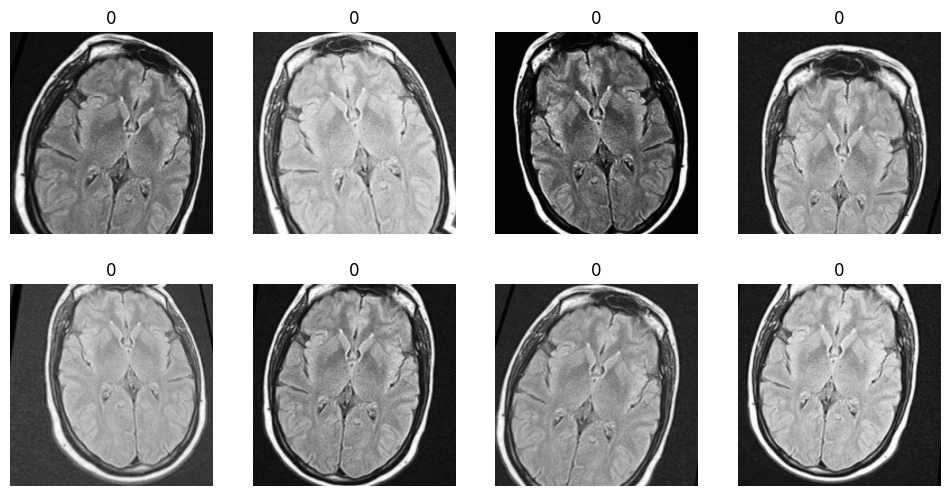

In [29]:
dls.show_batch(max_n=8, unique=True)

# 4. Load the Model

In [30]:
loss_func = LabelSmoothingCrossEntropy()

# VGG16
vgg = vision_learner(dls, vgg16, loss_func = loss_func, metrics=[accuracy, Precision(), Recall(), F1Score()])

# resnet50
resnet = vision_learner(dls, resnet50, loss_func = loss_func, metrics=[accuracy, Precision(), Recall(), F1Score()]).to_fp16()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:11<00:00, 47.7MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.4MB/s]


## VGG16

In [31]:
# Freeze all the layers
vgg.freeze()

# Replace the head with a binary classifier (adjust the last layer)
vgg.model[-1] = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(512, 2)  # Binary classification, so output 2 classes
)

## Resnet50

In [68]:
# Freeze all the layers
resnet.freeze()


# 5. Compile and Train the Model

## VGG16

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.701936,0.709151,0.485000,0.491468,0.963211,0.650847,01:25


SuggestedLRs(valley=0.3019951581954956)

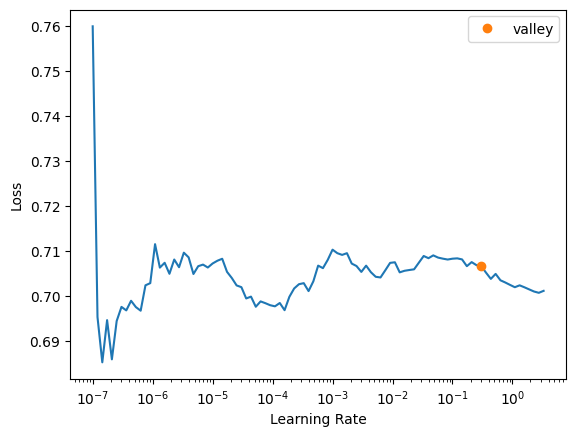

In [33]:
vgg.fit_one_cycle(1)
vgg.lr_find()               # find the best learning rate

In [34]:
vgg.fit_one_cycle(4, 0.301995, wd=0.2)  # train the model with the chosen learning rate.

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.708172,0.709151,0.485000,0.491468,0.963211,0.650847,01:38
1,0.703660,0.709151,0.485000,0.491468,0.963211,0.650847,01:37
2,0.698517,0.709151,0.485000,0.491468,0.963211,0.650847,01:36
3,0.703368,0.709151,0.485000,0.491468,0.963211,0.650847,01:36


SuggestedLRs(valley=2.511886486900039e-05)

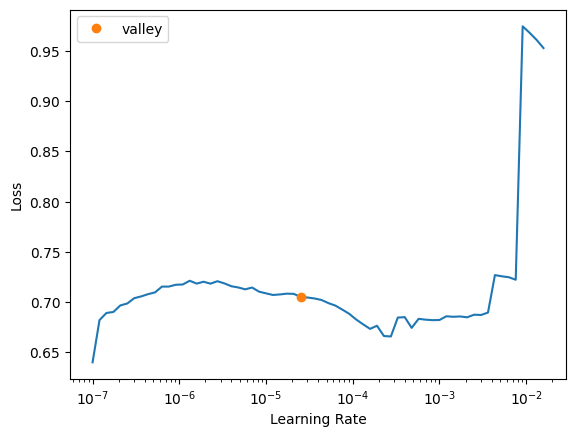

In [35]:
# Unfreeze and Fine-tune: Unfreeze the model and continue training to fine-tune the entire network.
vgg.unfreeze()
vgg.lr_find()

In [36]:
# continue training to fine-tune the entire network.
vgg_lr_ufrzn = slice(1e-5, 2e-5)
vgg.fit_one_cycle(5, vgg_lr_ufrzn, wd=0.2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.444257,0.333417,0.940000,0.951890,0.926421,0.938983,02:44
1,0.293009,0.307504,0.951667,0.916667,0.993311,0.953451,02:42
2,0.256435,0.250004,0.985000,0.983333,0.986622,0.984975,02:44
3,0.235095,0.243414,0.990000,0.989967,0.989967,0.989967,02:40
4,0.239304,0.241740,0.990000,0.989967,0.989967,0.989967,02:28


In [37]:
vgg.save('braintumorVGG16')
vgg.load('braintumorVGG16')

## RESNET50

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.158951,0.900007,0.591667,0.605469,0.518395,0.558559,00:33


SuggestedLRs(valley=0.0831763744354248)

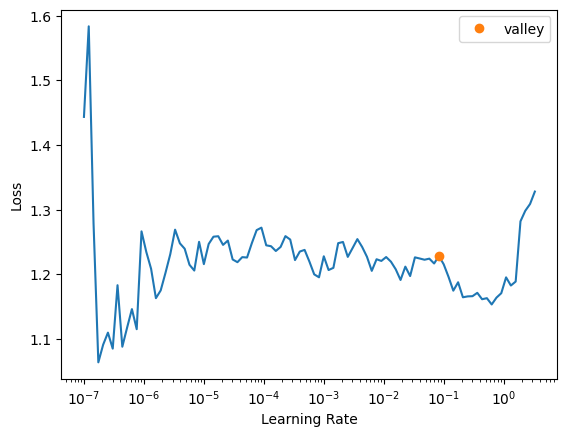

In [78]:
# then train for one cycle with the suggested lr
resnet.fit_one_cycle(1)
# find the best learning rate first
resnet.lr_find()

In [79]:
# Freeze all the layers
resnet.freeze()
resnet.fit_one_cycle(4, 0.08317637, wd=0.2)  # train the model with the chosen learning rate.

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.986707,0.878619,0.633333,0.672489,0.515050,0.583333,00:32
1,1.007689,5.146216,0.683333,0.677524,0.695652,0.686469,00:34
2,0.814456,15.114094,0.700000,0.685358,0.735786,0.709677,00:33
3,0.688624,7.616937,0.753333,0.764912,0.729097,0.746575,00:31


SuggestedLRs(valley=0.00019054606673307717)

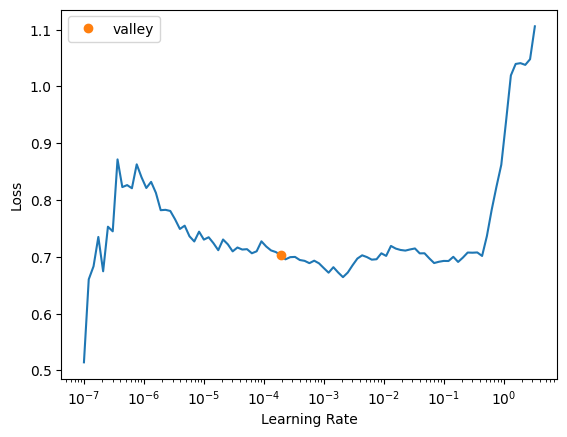

In [80]:
# Unfreeze and Fine-tune: Unfreeze the model and continue training to fine-tune the entire network.
resnet.unfreeze()
resnet.lr_find()

In [81]:
# continue training to fine-tune the entire network.
resnet_lr_ufrzn = slice(1e-4, 1e-2)
resnet.fit_one_cycle(5, resnet_lr_ufrzn, wd=0.2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.640079,8.907248,0.746667,0.826667,0.622074,0.709924,00:37
1,0.640201,11.647066,0.746667,0.710602,0.829431,0.765432,00:38
2,0.608635,4.803158,0.758333,0.737654,0.799331,0.767255,00:39
3,0.594643,11.155448,0.758333,0.800781,0.685619,0.738739,00:36
4,0.590019,9.826059,0.770000,0.774744,0.759197,0.766892,00:38


In [82]:
resnet.save('braintumorRESNET50')
resnet.load('braintumorRESNET50')

# 6. Evaluate the Model

## VGG16

In [83]:
vgg_score = vgg.validate(dl=dls.valid)
vgg_score

(#5) [0.2414436638355255,0.9900000095367432,0.9899665551839465,0.9899665551839465,0.9899665551839465]

## RESNET50

In [93]:
resnet_score = resnet.validate(dl=dls.valid)
resnet_score

(#5) [9.826059341430664,0.7699999809265137,0.7747440273037542,0.7591973244147158,0.766891891891892]

It appears that the VGG model has achieved significantly better evaluation results compared to the ResNet model based on the metrics provided. Let’s break down the results for both models:

VGG Model Evaluation Results

- Validation Loss: 0.2414
- Accuracy: 0.9900 (99.00%)
- Precision: 0.9899 (98.99%)
- Recall: 0.9899 (98.99%)
- F1 Score: 0.9899 (98.99%)

ResNet Model Evaluation Results

- Validation Loss: 9.8260
- Accuracy: 0.7700 (77.00%)
- Precision: 0.7747 (77.47%)
- Recall: 0.7592 (75.92%)
- F1 Score: 0.7669 (76.69%)

Interpretation
- Validation Loss: The VGG model has a much lower validation loss (0.2414) compared to the ResNet model (9.8260). This indicates that the VGG model is better at minimizing the loss on the validation set.

- Accuracy:The VGG model achieves an accuracy of 99.00%, whereas the ResNet model achieves 77.00%. This suggests that the VGG model is significantly better at correctly classifying the validation samples.

- Precision, Recall, and F1 Score:The VGG model has higher precision, recall, and F1 scores compared to the ResNet model. This means the VGG model is better at both identifying the positive class correctly (precision) and capturing the true positive rate (recall), resulting in a better balance between precision and recall (F1 score).

# 7. Results

## VGG16

In [86]:
_, targs, preds = vgg.get_preds(dl=dls.valid, with_decoded=True) # retrieve predictions and target labels.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

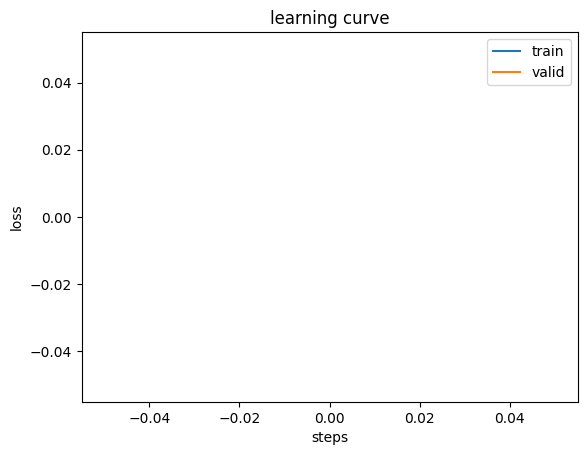

In [87]:
# Plot learning curve
vgg.recorder.plot_loss()

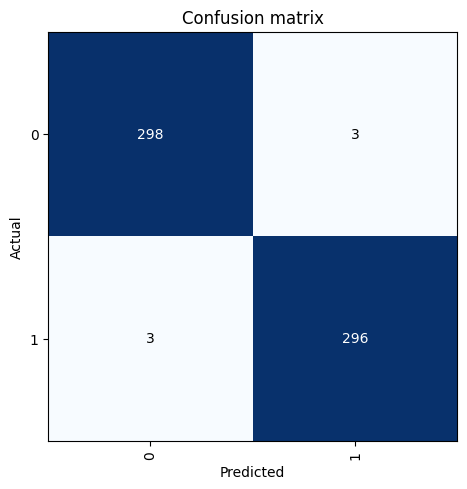

In [88]:
# Plot the confusion matrix to understand the distribution of predicted versus actual labels in a classification task.

vgg_interp = ClassificationInterpretation.from_learner(vgg, dl=dls.valid)
vgg_interp.plot_confusion_matrix()

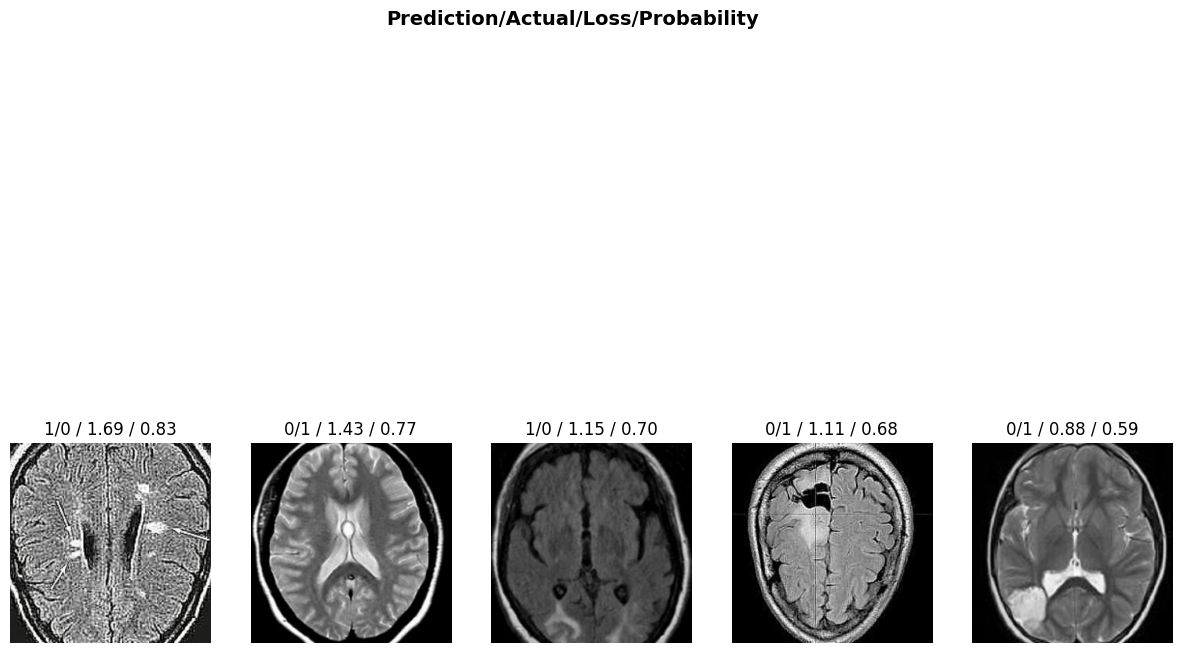

In [89]:
# Visualize the Grad-CAM (Gradient-weighted Class Activation Mapping)
vgg_interp.plot_top_losses(k=5, nrows=1, figsize=(15,11))

## RESNET50

In [90]:
_, targs, preds = resnet.get_preds(dl=dls.valid, with_decoded=True) # retrieve predictions and target labels.

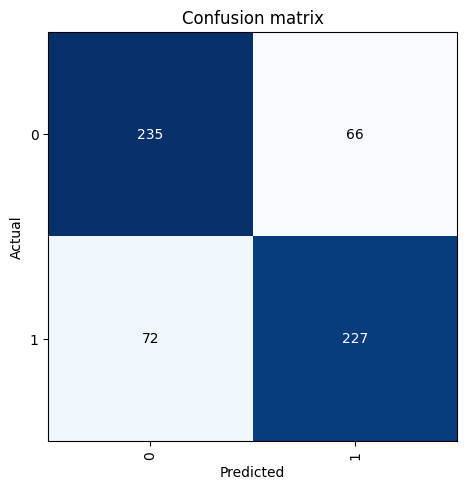

In [91]:
# Plot the confusion matrix to understand the distribution of predicted versus actual labels in a classification task.

resnet_interp = ClassificationInterpretation.from_learner(resnet, dl=dls.valid)
resnet_interp.plot_confusion_matrix()

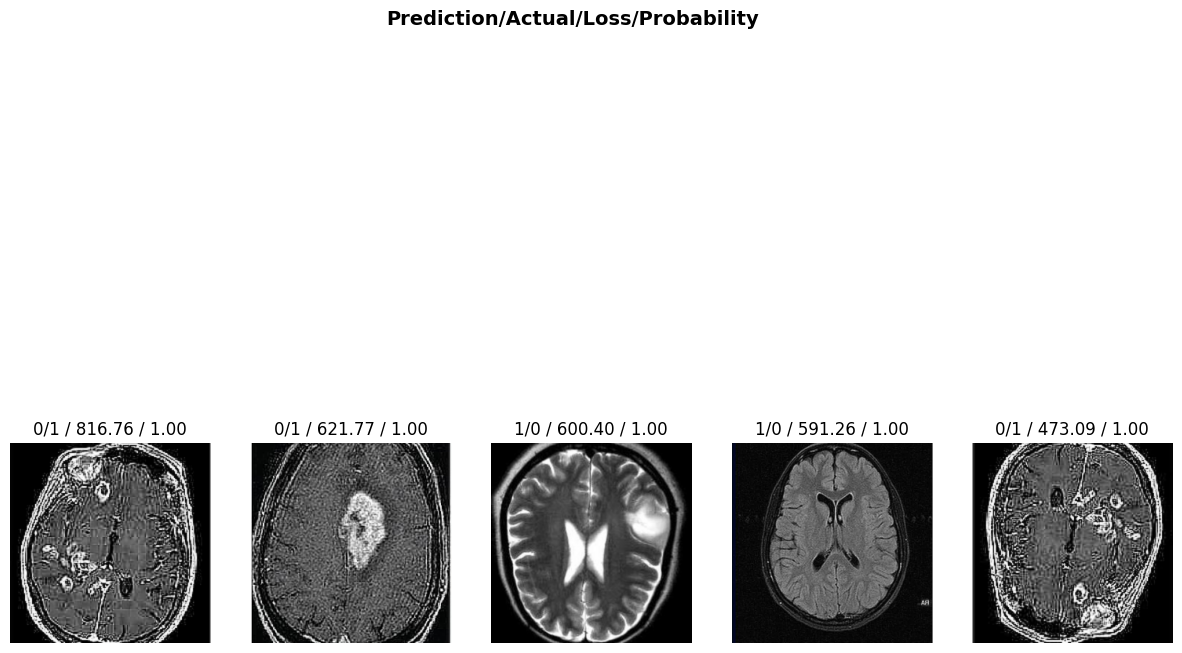

In [92]:
# Visualize the Grad-CAM (Gradient-weighted Class Activation Mapping)
resnet_interp.plot_top_losses(k=5, nrows=1, figsize=(15,11))